In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

In [3]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid']=True

In [4]:
ts_data = pd.read_excel("pma.xlsx")
ts_data = ts_data.reset_index().drop("index", axis=1)
ts_data["time"] = pd.to_datetime(ts_data["time"])
ts_data = ts_data.set_index("time")
ts_data.head()

,pma,tmp
time,,
2016-01-01 00:00:00,1042.909320,6.933756
2016-01-01 01:00:00,982.529002,6.405644
2016-01-01 02:00:00,983.240592,5.932445
2016-01-01 03:00:00,1002.780354,5.503807
2016-01-01 04:00:00,1011.657004,5.112056


### Feature Engineering

In [23]:
seasons = [1, 2, 3, 4]

def map_season(month, day):
    if (month == 12 and day >= 21) or (month == 1) or (month == 2) or (month == 3 and day < 21):
        return seasons[0]  # Winter
    elif (month == 3 and day >= 21) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return seasons[1]  # Spring
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 21):
        return seasons[2]  # Summer
    else:
        return seasons[3]  # Fall


def is_special_day(date):
    special_days = ['2016-07-06', '2017-06-25', '2016-09-12', '2017-09-01']
    special_days = pd.to_datetime(special_days).date

    return int(date in special_days)


def create_features(df):
    """
    Create time series features based on the time series index.
    """
    df = df.copy()
    df["date"] = df.index.date
    df['hour'] = df.index.hour
    df['dayofweek'] = ((df.index.dayofweek + 8) % 7) + 1
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df["is_special_day"] = df.apply(lambda row: is_special_day(row.date), axis=1)
    df['season'] = df.apply(lambda row: map_season(row.month, row.dayofmonth), axis=1)

    return df

df = create_features(ts_data)

df.head()

,pma,tmp,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,is_special_day,season
time,,,,,,,,,,,,
2016-01-01 00:00:00,1042.909320,6.933756,2016-01-01,0,6,1,1,2016,1,1,0,1
2016-01-01 01:00:00,982.529002,6.405644,2016-01-01,1,6,1,1,2016,1,1,0,1
2016-01-01 02:00:00,983.240592,5.932445,2016-01-01,2,6,1,1,2016,1,1,0,1
2016-01-01 03:00:00,1002.780354,5.503807,2016-01-01,3,6,1,1,2016,1,1,0,1
2016-01-01 04:00:00,1011.657004,5.112056,2016-01-01,4,6,1,1,2016,1,1,0,1


### Data cleaning

#### Checking for outliers, missing data and duplicated

In [6]:
total_missing_values = df.isna().sum().sum()
total_duplicates = df.duplicated().sum()

print(f'total of missing values: {total_missing_values}')
print(f'total of duplicated values: {total_duplicates}')

total of missing values: 0
total of duplicated values: 0


### EDA

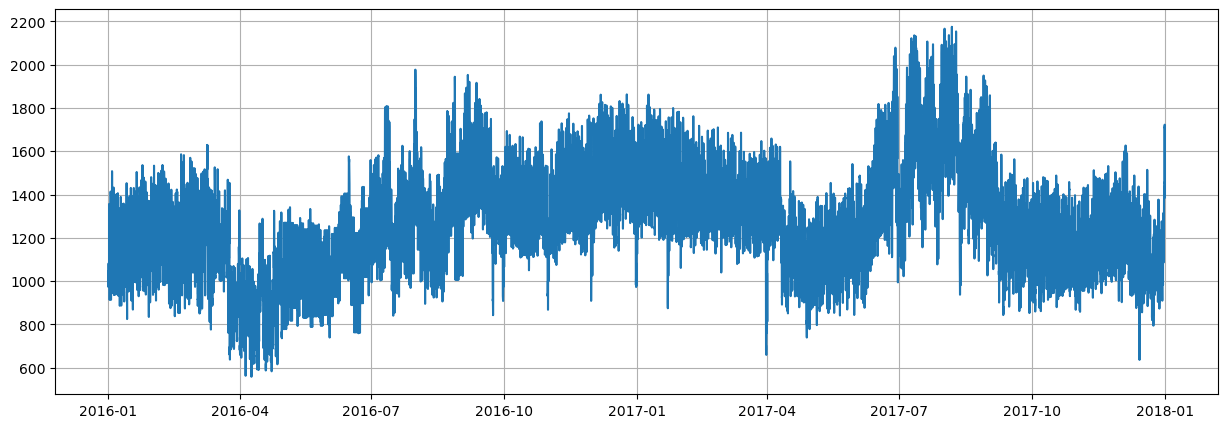

In [7]:
plt.plot(df.index, df["pma"])

<Axes: xlabel='hour', ylabel='pma'>

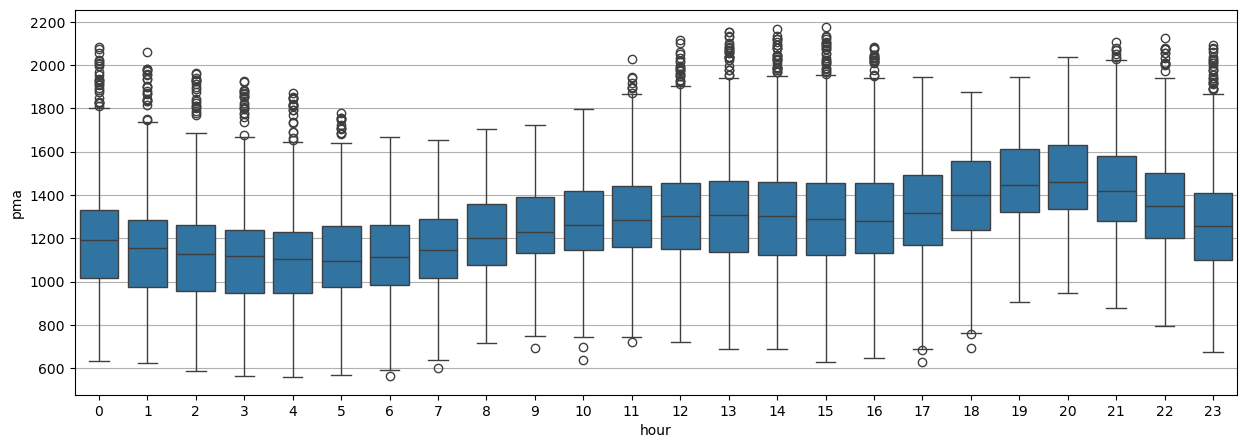

In [28]:
sns.boxplot(data=df, x='hour', y='pma')

**Analysis**

<mark>TODO</mark>

<Axes: xlabel='season', ylabel='pma'>

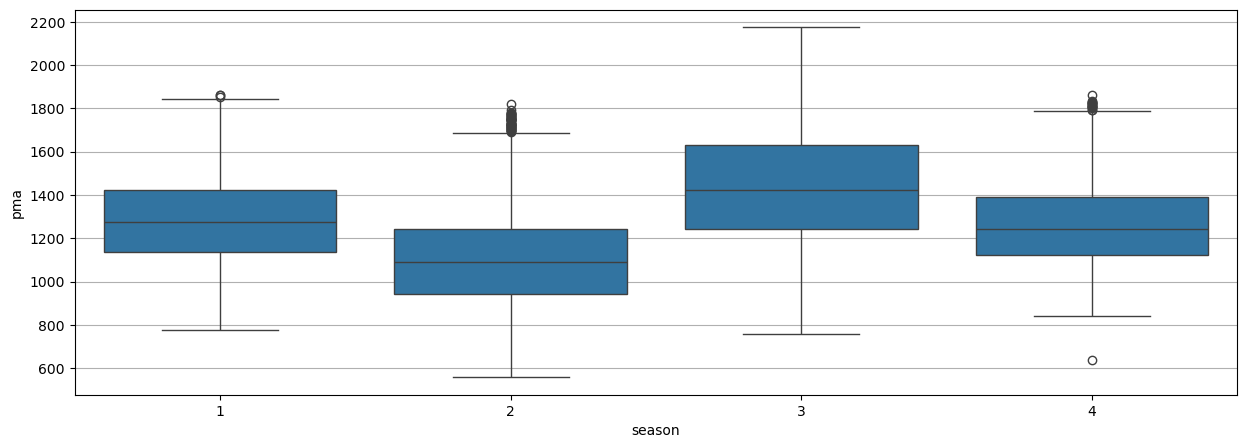

In [16]:
sns.boxplot(data=df, x='season', y='pma')

### Trends

#### PMA over all time

Here, we will try to see the development of the maximum power demand over time in 2016 and 2017 by months

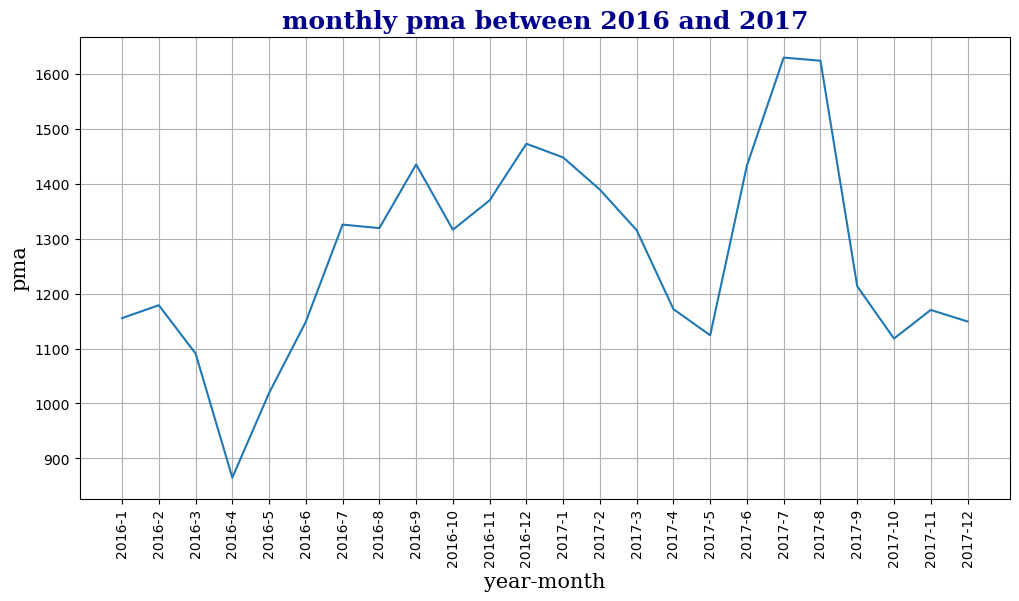

In [9]:
# group
year_month_grouped_pma = df.groupby(['year', 'month']).pma.agg(years_monthly_pma='mean')

title_style = {'family':'serif','color':'darkblue','size':18, 'weight':'bold'}
labels_style = {'family':'serif','color':'black','size':15}
def line_plot(data, x, y, title='', xlabel='', ylabel='', rotate_x=0):
    plt.figure(figsize=[12, 6])
    plt.title(title, fontdict=title_style)
    plt.ylabel(ylabel, fontdict=labels_style)
    plt.xlabel(xlabel, fontdict=labels_style)
    plt.xticks(rotation=rotate_x)
    sns.lineplot(data=data, x=x, y=y)
    plt.show()

# adding a column for the combination year-month
year_month_grouped_pma['year_month'] = year_month_grouped_pma.index.map(lambda x: f'{x[0]}' + '-' + f'{x[1]}')
# year_month_grouped_pma

# plotting the data
line_plot(year_month_grouped_pma, 'year_month', 'years_monthly_pma', 'monthly pma between 2016 and 2017', 'year-month', 'pma', 90)

As we notice, for now, maximum power demand increases mostly during summer from May till October.  
To see this better, let us take the average pma between the two years for ech month:

#### PMA over months

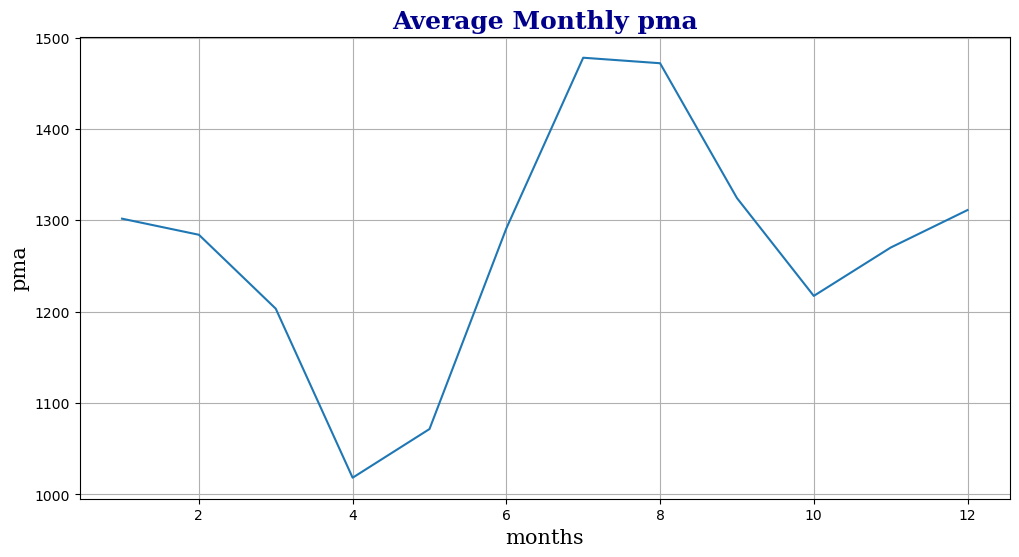

In [10]:
monthly_grouped_pma = year_month_grouped_pma.groupby('month').years_monthly_pma.agg(average_monthly_pma='mean')
# monthly_grouped_pma
line_plot(monthly_grouped_pma, 'month', 'average_monthly_pma', 'Average Monthly pma', 'months', 'pma')

<Axes: xlabel='month', ylabel='pma'>

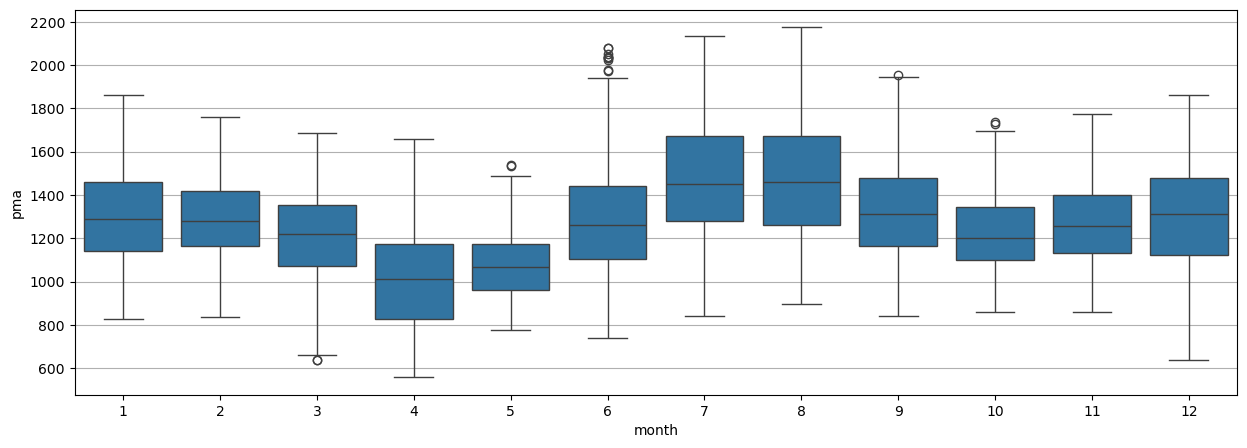

In [12]:
sns.boxplot(data=df, x='month', y='pma')

Great, It is clear enough now.

#### PMA over days

Now, let us find the hours of the day with most power demand.

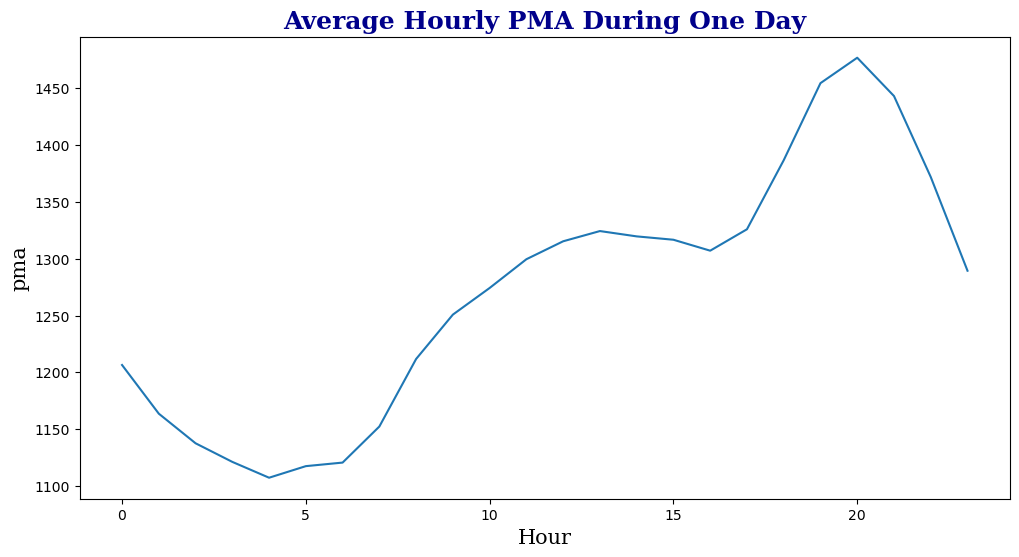

In [71]:
hourly_grouped_pma = df.groupby('hour').pma.agg(hourly_pma='mean')
#hourly_grouped_pma
line_plot(hourly_grouped_pma, 'hour', 'hourly_pma', 'Average Hourly PMA During One Day', 'Hour', 'pma')

<Axes: xlabel='hour', ylabel='pma'>

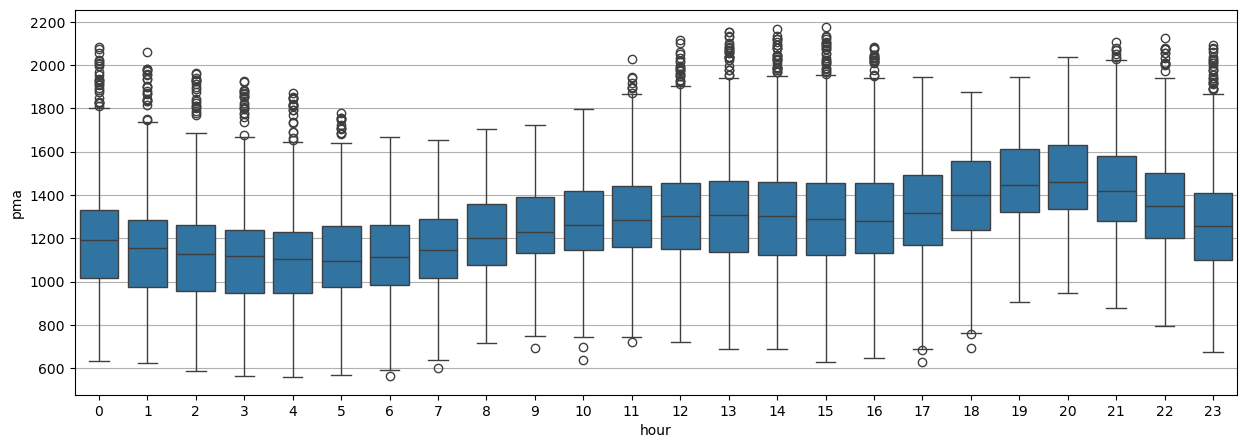

In [13]:
sns.boxplot(data=df, x='hour', y='pma')

<mark>TODO</mark>
- Add analysis

However, this one is for both two years, let us do it for each season and try to compare.

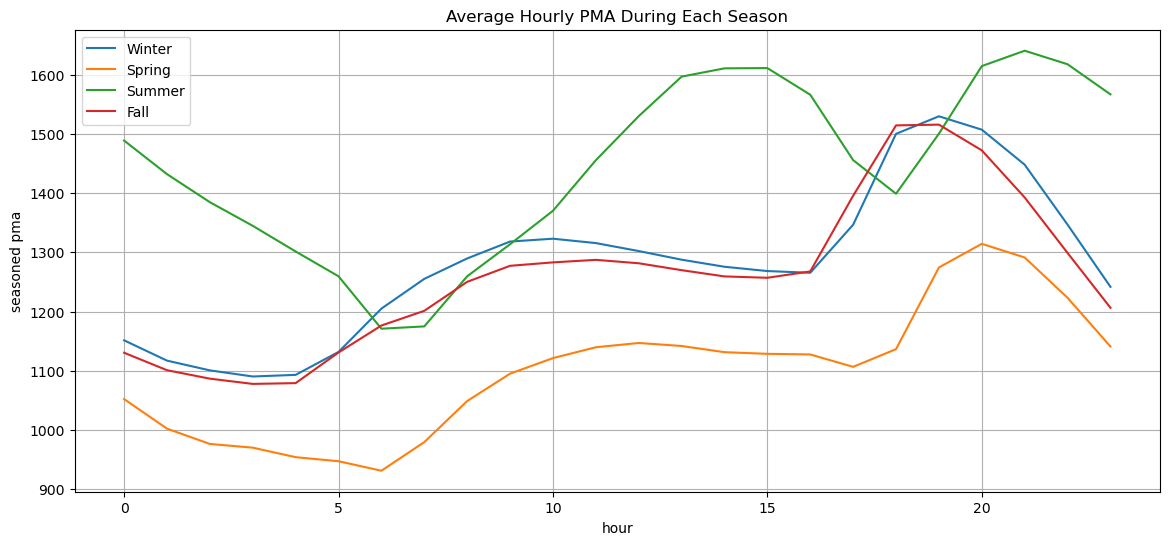

In [26]:
seasoned_hourly_grouped_pma = df.groupby(['season', 'hour']).pma.agg(seasoned_hourly_pma='mean')
fall_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Fall']
winter_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Winter']
spring_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Spring']
summer_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Summer']

plt.figure(figsize=[14, 6])
plt.title('Average Hourly PMA During Each Season')
plt.ylabel('seasoned pma')
plt.xlabel('hour')

season_num_to_name = {
    1: "Winter",
    2: "Spring",
    3: "Summer",
    4: "Fall"
}

for season in seasons:
    seasoned_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')==season]
    #line_plot(seasoned_hourly, 'hour', 'seasoned_hourly_pma', f'Average Hourly Demand in {season}', 'Hour', 'pma')
    sns.lineplot(data=seasoned_hourly, x='hour', y='seasoned_hourly_pma', label=season_num_to_name[season])

plt.show()

#### PMA in Week Days

We'll now discover which day in the week has the highest consumption of energy

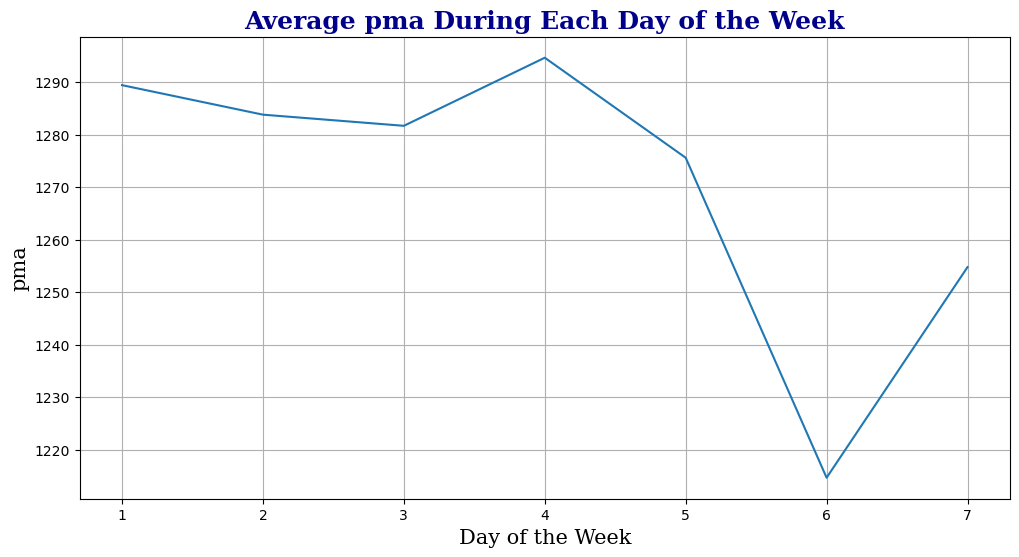

In [25]:
# We plot the average usage of each day of the week
dayName_grouped_pma = df.groupby('dayofweek').pma.agg(average_pma='mean')

# We sort the days of the week
dayName_grouped_pma = dayName_grouped_pma.reindex(range(8))

# We plot the data
line_plot(dayName_grouped_pma, 'dayofweek', 'average_pma', 'Average pma During Each Day of the Week', 'Day of the Week', 'pma')


> We notice that the consumption is low in the weekends because most of people rest or go for picnics

#### PMA in special days (Eids Days)

Let us discover how was the usage of people in "Eids", we might find some high usage due to family gathering



In [35]:
# We first define the special days (Eids in 2016 and 2017)
special_days_df = df.loc[df["is_special_day"] == 1]
special_days_df

,pma,tmp,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,is_special_day,season
time,,,,,,,,,,,,
2016-07-06 00:00:00,1538.428850,23.713276,2016-07-06,0,4,3,7,2016,188,6,1,3
2016-07-06 01:00:00,1462.136981,22.833816,2016-07-06,1,4,3,7,2016,188,6,1,3
2016-07-06 02:00:00,1406.681766,22.077255,2016-07-06,2,4,3,7,2016,188,6,1,3
2016-07-06 03:00:00,1324.151848,21.413419,2016-07-06,3,4,3,7,2016,188,6,1,3
2016-07-06 04:00:00,1307.678685,20.822039,2016-07-06,4,4,3,7,2016,188,6,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-01 19:00:00,1708.430359,31.203801,2017-09-01,19,6,3,9,2017,244,1,1,3
2017-09-01 20:00:00,1806.951276,29.043954,2017-09-01,20,6,3,9,2017,244,1,1,3
2017-09-01 21:00:00,1852.200849,27.618178,2017-09-01,21,6,3,9,2017,244,1,1,3


Let's compare the usage in Eid days to the overall usage

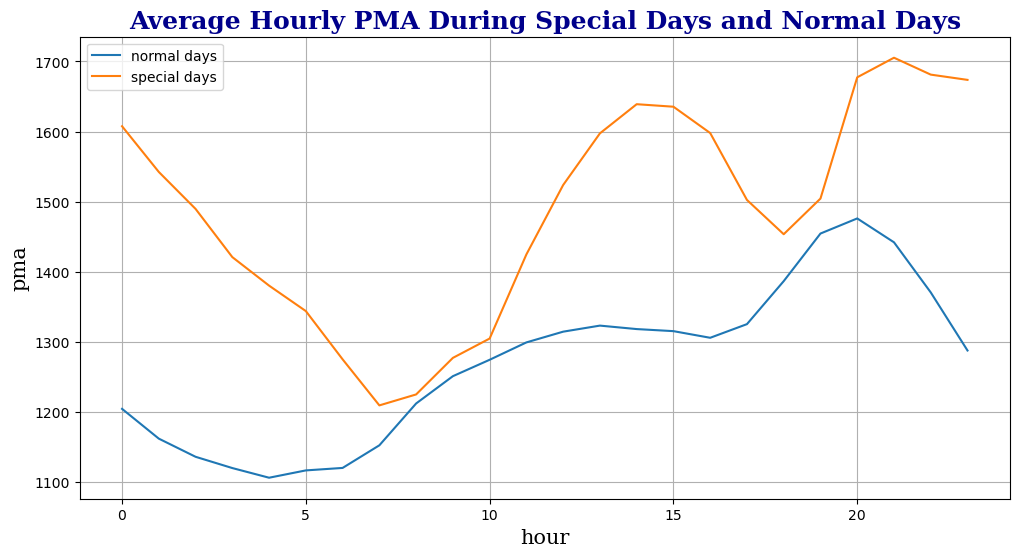

<Axes: xlabel='is_special_day', ylabel='pma'>

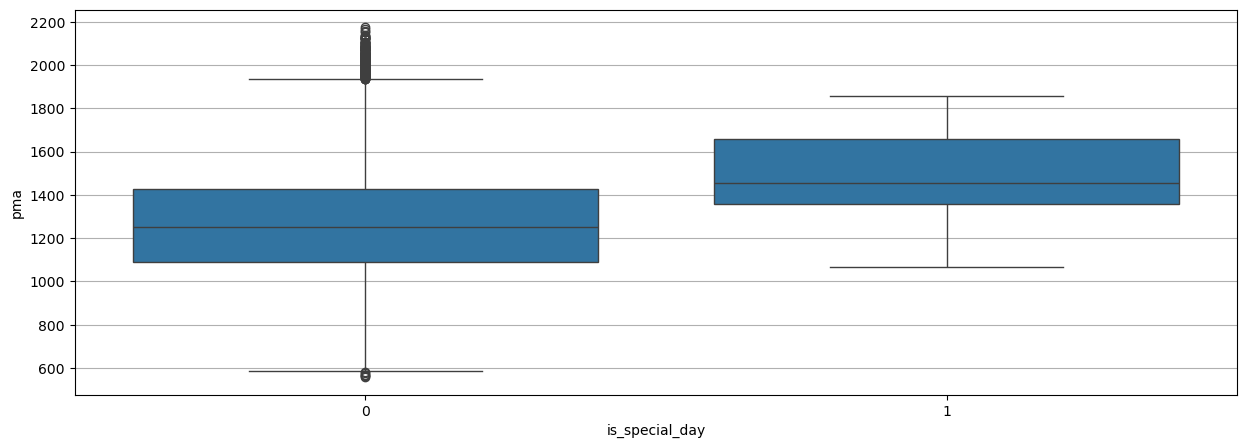

In [38]:
# We plot a comparison between the average hourly pma in the special days and the average hourly pma in the normal days
normal_days_df = df[~df['date'].isin(special_days)]
normal_days_hourly_grouped_pma = normal_days_df.groupby('hour').pma.agg(normal_hourly_pma='mean')
special_days_hourly_grouped_pma = special_days_df.groupby('hour').pma.agg(special_hourly_pma='mean')
# we plot the comparison
plt.figure(figsize=[12, 6])
plt.title('Average Hourly PMA During Special Days and Normal Days', fontdict=title_style)
plt.ylabel('pma', fontdict=labels_style)
plt.xlabel('hour', fontdict=labels_style)
sns.lineplot(data=normal_days_hourly_grouped_pma, x='hour', y='normal_hourly_pma', label='normal days')
sns.lineplot(data=special_days_hourly_grouped_pma, x='hour', y='special_hourly_pma', label='special days')
plt.show()

sns.boxplot(data=df, x='is_special_day', y='pma')

> It's remarkable that the usage in Eids is higher than in the normal days due to family gathering and especially that Eids were in the summer

#### Key notes

* Power demand reaches its maximum values during summer. Which logical, most people are in holidays thus staying at home most of the time compared to the rest of the year.
* During one day, PMA reaches its climax at around 8pm.
* During Winter, max demand is at its peak before 8pm, and after that time it starts decreasing. This could be due to many reasons. One of them is that people tend to sleep earlier at winter. Meanwhile during summer, it reaches its climax after 8pm and higher values as well 1pm and 4pm. Because, most people are at their homes with their AC (Air Conditioner) on at those times due to high temperatures outside.
* Demand is low in all seasons during night (most logically) and medium during day where everyone are doing their activities and daily tasks.
* Demand is low in weekends which is also logic because people are resting and companies are off
* Demand is higher in Eids because of family gathering which cause a high consumption of electricity (lights on everywhere, hair dryer for women..etc)

### Data preprocessing

#### Grouping by days
- Our data has each hour in a row, so we need to take the median of each 24 hours to represent that day
- We choose the median to avoid outliers' effect.

In [47]:
df_daily = df.groupby("date").agg({"pma": "median", "tmp": "median", "year": "min", "month": "min", "dayofmonth": "min", "dayofyear": "min", "is_special_day": "min", "season": "min", "dayofweek": "min", "quarter": "min"})

df_daily.index = pd.to_datetime(df_daily.index)

df_daily.head()

,pma,tmp,year,month,dayofmonth,dayofyear,is_special_day,season,dayofweek,quarter
date,,,,,,,,,,
2016-01-01,1016.879030,9.470275,2016,1,1,1,0,1,6,1
2016-01-02,1132.572358,10.256234,2016,1,2,2,0,1,7,1
2016-01-03,1179.197928,11.098879,2016,1,3,3,0,1,1,1
2016-01-04,1157.773987,13.772329,2016,1,4,4,0,1,2,1
2016-01-05,1147.839757,12.807576,2016,1,5,5,0,1,3,1


#### Cyclic attribute representation
Since our data is a time series, we have many attributes that are cyclic, for example: month, which starts with 0 and ends with 11. We all know that month 11 (December) and month 1 (January) are right next to each other, but with this representation 11 is way bigger than 1, so if we apply any clustering or regression algorithm it will think that they are very appart from each other and fail to determine the real patterns in the data.